In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'

filefolder = 'anonymisedData/'

In [2]:
plot_params = {'legend.fontsize': 'x-large',
               'figure.figsize': (10, 8),
               'axes.labelsize': 'x-large',
               'axes.titlesize': 'x-large',
               'xtick.labelsize': 'x-large',
               'ytick.labelsize': 'x-large'}
for param, value in plot_params.items():
    mpl.rcParams[param] = value

# Load Data

In [3]:
asmt_df = pd.read_csv(filefolder + 'assessments.csv')
print('Loaded asmt_df: length', len(asmt_df))
asmt_df.head()

Loaded asmt_df: length 206


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [4]:
courses_df = pd.read_csv(filefolder + 'courses.csv')
print('Loaded courses_df: length', len(courses_df))
courses_df.head()

Loaded courses_df: length 22


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [5]:
stu_asmt_df = pd.read_csv(filefolder + 'studentAssessment.csv')
print('Loaded stu_asmt_df: length', len(stu_asmt_df))
stu_asmt_df.head()

Loaded stu_asmt_df: length 173912


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [6]:
stu_info_df = pd.read_csv(filefolder + 'studentInfo.csv')
print('Loaded stu_info_df: length', len(stu_info_df))
stu_info_df.head()

Loaded stu_info_df: length 32593


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [7]:
stu_reg_df = pd.read_csv(filefolder + 'studentRegistration.csv')
print('Loaded stu_reg_df: length', len(stu_reg_df))
stu_reg_df.head()

Loaded stu_reg_df: length 32593


,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [8]:
stu_vle_df = pd.read_csv(filefolder + 'studentVle.csv')
print('Loaded stu_vle_df: length', len(stu_vle_df))
stu_vle_df.head()

Loaded stu_vle_df: length 10655280


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [9]:
vle_df = pd.read_csv(filefolder + 'vle.csv')
print('Loaded vle_df: length', len(vle_df))
vle_df.head()

Loaded vle_df: length 6364


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


## Functions and dicts for linking tables

In [10]:
id_site_to_activity = pd.Series(vle_df['activity_type'].values, index=vle_df['id_site']).to_dict()

In [11]:
stu_info_columns = ['final_result', 'age_band']
stu_info_dict = pd.DataFrame(stu_info_df[stu_info_columns].values, columns=stu_info_columns,
                             index=stu_info_df['id_student']).to_dict()

In [12]:
asmt_columns = ['code_module', 'code_presentation', 'weight']
asmt_dict = pd.DataFrame(asmt_df[asmt_columns].values, columns=asmt_columns,
                         index=asmt_df['id_assessment']).to_dict()

# Exploration
Explore how the student interaction (number of clicks) varies with age group.

### Table of student performance
Each row represents a unique student - course - session combination.

In [14]:
for col in asmt_columns:
    stu_asmt_df[col] = stu_asmt_df['id_assessment'].map(asmt_dict[col])
stu_asmt_df['weighted_score'] = stu_asmt_df['score'] * stu_asmt_df['weight']
scores = stu_asmt_df.groupby(['id_student', 'code_module', 'code_presentation'], as_index=False).agg(
    {'weight': 'sum', 'weighted_score': 'sum'})
scores['final_score'] = scores['weighted_score'] / scores['weight']
scores.head()

,id_student,code_module,code_presentation,weight,weighted_score,final_score
0,6516,AAA,2014J,100.0,6350.0,63.50
1,8462,DDD,2013J,40.0,3490.0,87.25
2,8462,DDD,2014J,50.0,4300.0,86.00
3,11391,AAA,2013J,100.0,8240.0,82.40
4,23629,BBB,2013B,25.0,1669.0,66.76


Add score columns to student info table

In [15]:
stu_info_df = stu_info_df.merge(scores[['id_student', 'code_module', 'code_presentation',
                                        'final_score', 'weighted_score']],
                                on=['id_student', 'code_module', 'code_presentation'])
stu_info_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_score,weighted_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.4,8240.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,65.4,6540.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.3,7630.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,55.0,5500.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,66.9,6690.0


Look specifically at module DDD

In [14]:
module = 'DDD'
df_slice = stu_vle_df[stu_vle_df['code_module']==module]
len(df_slice)

2166486

Get the total number of clicks per activity type for each student in each module session.

In [15]:
id_ = ['id_student', 'code_module', 'code_presentation'] # Common identifier
clicks = df_slice.groupby(id_ + ['id_site'], as_index=False).agg({'sum_click': 'sum'})
clicks['activity_type'] = clicks['id_site'].map(id_site_to_activity)
activity_clicks = clicks.groupby(id_ + ['activity_type'], as_index=False).agg({'sum_click': 'sum'})
# activity_clicks = clicks
for col in stu_info_columns:
    activity_clicks[col] = activity_clicks['id_student'].map(stu_info_dict[col])
result_dict = {'Pass': 'Pass', 'Distinction': 'Pass', 'Fail': 'Fail'}
activity_clicks['final_result'] = activity_clicks['final_result'].map(result_dict)
activity_clicks = activity_clicks.dropna()
activity_clicks.head()

,id_student,code_module,code_presentation,activity_type,sum_click,final_result,age_band
12,24213,DDD,2014B,externalquiz,9,Pass,0-35
13,24213,DDD,2014B,forumng,778,Pass,0-35
14,24213,DDD,2014B,homepage,325,Pass,0-35
15,24213,DDD,2014B,oucollaborate,26,Pass,0-35
16,24213,DDD,2014B,oucontent,262,Pass,0-35


Find the trends for student interaction (clicks) vs final result (pass/fail), for different age groups and activity types.

In [17]:
activity_types = ['oucontent', 'forumng']
click_dist = activity_clicks.groupby(['activity_type', 'final_result', 'age_band'], as_index=False).agg(
    {'sum_click': 'mean'})
click_dist[click_dist['activity_type'].isin(activity_types)]

,activity_type,final_result,age_band,sum_click
6,forumng,Fail,0-35,133.403766
7,forumng,Fail,35-55,193.736301
8,forumng,Fail,55<=,225.285714
9,forumng,Pass,0-35,365.718391
10,forumng,Pass,35-55,625.022284
11,forumng,Pass,55<=,711.800000
30,oucontent,Fail,0-35,107.618613
31,oucontent,Fail,35-55,109.320872
32,oucontent,Fail,55<=,75.142857
33,oucontent,Pass,0-35,168.299432


Make boxplots of the number of clicks for different age groups and final result (pass/fail). Compare distributions for the activity types "oucontent" and "forumng".

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


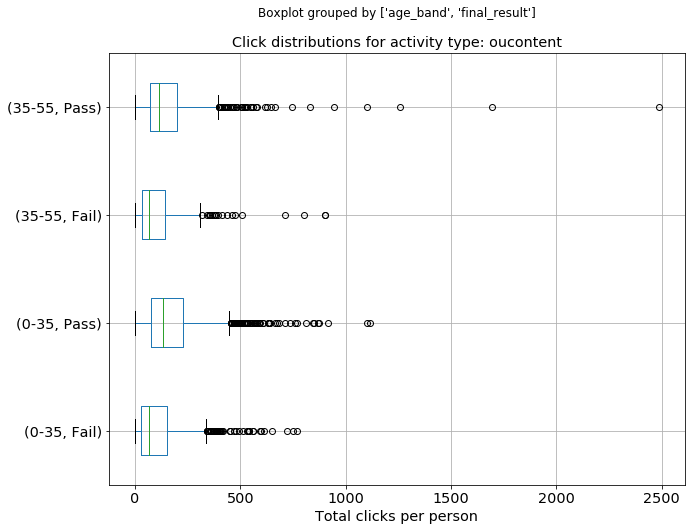

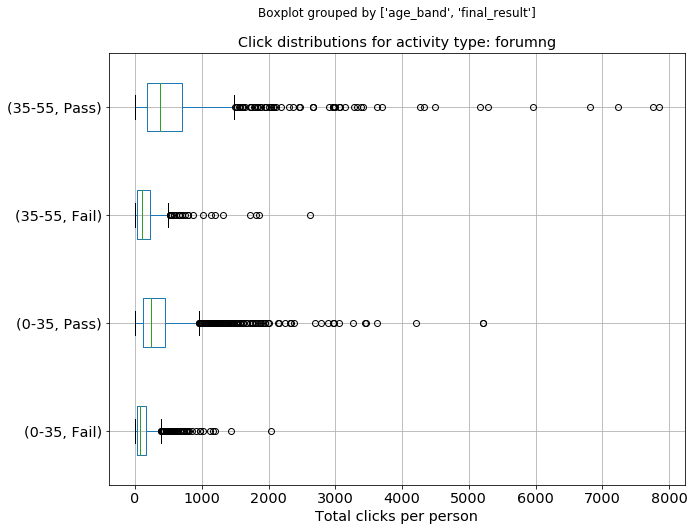

In [18]:
activity_types = ['oucontent', 'forumng']
ages = ['0-35', '35-55']

n = len(activity_types)
for i, activity in enumerate(activity_types):
    df_slice = activity_clicks[(activity_clicks['age_band'].isin(ages)) &
                               (activity_clicks['activity_type']==activity)]
    df_slice.boxplot('sum_click', by=['age_band', 'final_result'], vert=False)
    plt.xlabel('Total clicks per person')
    plt.title('Click distributions for activity type: ' + activity)

plt.show()